#  Brain Tumor Classification 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-11-13 12:46:39.408188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763037999.597821      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763037999.648190      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


 # DataFrame

In [2]:
def create_dataframe(directory):
    classes, paths = zip(*[
        (label, os.path.join(directory, label, file))
        for label in os.listdir(directory)
        if os.path.isdir(os.path.join(directory, label))
        for file in os.listdir(os.path.join(directory, label))
    ])
    return pd.DataFrame({'Class Path': paths, 'Class': classes})

# Validation Data

In [3]:
train_path = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_path = '/kaggle/input/brain-tumor-mri-dataset/Testing'

train_df = create_dataframe(train_path)
test_df = create_dataframe(test_path)
valid_df, test_df = train_test_split(test_df, train_size=0.5, stratify=test_df['Class'], random_state=42)


# Data Generators

In [4]:
batch_size = 32
img_size = (299, 299)

train_datagen = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))
val_test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col='Class Path', y_col='Class',
    target_size=img_size, batch_size=batch_size)

valid_generator = val_test_datagen.flow_from_dataframe(
    valid_df, x_col='Class Path', y_col='Class',
    target_size=img_size, batch_size=batch_size)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df, x_col='Class Path', y_col='Class',
    target_size=img_size, batch_size=batch_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


# model Sequential

In [5]:
input_shape = (299, 299, 3)
base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=input_shape, pooling='max')

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(4, activation='softmax') 
])

model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

I0000 00:00:1763038017.878887      39 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

# Training Model

In [6]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    shuffle=False
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1763038053.379451      96 service.cc:148] XLA service 0x7cbe64002200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763038053.380381      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763038055.953914      96 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1763038072.104817      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763038072.343926      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763038073.701536      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763038073.9432

178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.7702 - loss: 0.6826 - precision: 0.8398 - recall: 0.6675

E0000 00:00:1763038175.001004      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763038175.210181      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763038176.274979      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763038176.504177      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763038177.423773      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.7708 - loss: 0.6807 - precision: 0.8402 - recall: 0.6685

E0000 00:00:1763038198.015410      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763038198.251805      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763038198.777468      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1763038199.037715      98 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


179/179 ━━━━━━━━━━━━━━━━━━━━ 180s 641ms/step - accuracy: 0.7714 - loss: 0.6788 - precision: 0.8407 - recall: 0.6694 - val_accuracy: 0.9603 - val_loss: 0.1163 - val_precision: 0.9615 - val_recall: 0.9542
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 452ms/step - accuracy: 0.9786 - loss: 0.0629 - precision: 0.9809 - recall: 0.9748 - val_accuracy: 0.9695 - val_loss: 0.0687 - val_precision: 0.9739 - val_recall: 0.9695
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 451ms/step - accuracy: 0.9940 - loss: 0.0202 - precision: 0.9941 - recall: 0.9939 - val_accuracy: 0.9756 - val_loss: 0.0811 - val_precision: 0.9756 - val_recall: 0.9756
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 450ms/step - accuracy: 0.9942 - loss: 0.0181 - precision: 0.9942 - recall: 0.9942 - val_accuracy: 0.9878 - val_loss: 0.0327 - val_precision: 0.9893 - val_recall: 0.9878
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 451ms/step - accuracy: 0.9962 - loss: 0.0153 - precision: 0.9962 - recall: 0.9957 - val_accuracy: 0.9221 - val_los

# Model evaluation

In [7]:
train_score = model.evaluate(train_generator, verbose=1)
val_score = model.evaluate(valid_generator, verbose=1)
test_score = model.evaluate(test_generator, verbose=1)

print(f"\n Train Accuracy: {train_score[1]*100:.2f}%")
print(f" Validation Accuracy: {val_score[1]*100:.2f}%")
print(f" Test Accuracy: {test_score[1]*100:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 36s 202ms/step - accuracy: 0.9998 - loss: 9.7598e-04 - precision: 0.9998 - recall: 0.9998
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9851 - loss: 0.0921 - precision: 0.9851 - recall: 0.9848
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.9820 - loss: 0.0758 - precision: 0.9820 - recall: 0.9820

 Train Accuracy: 99.96%
 Validation Accuracy: 98.63%
 Test Accuracy: 98.63%


# Show samples of data

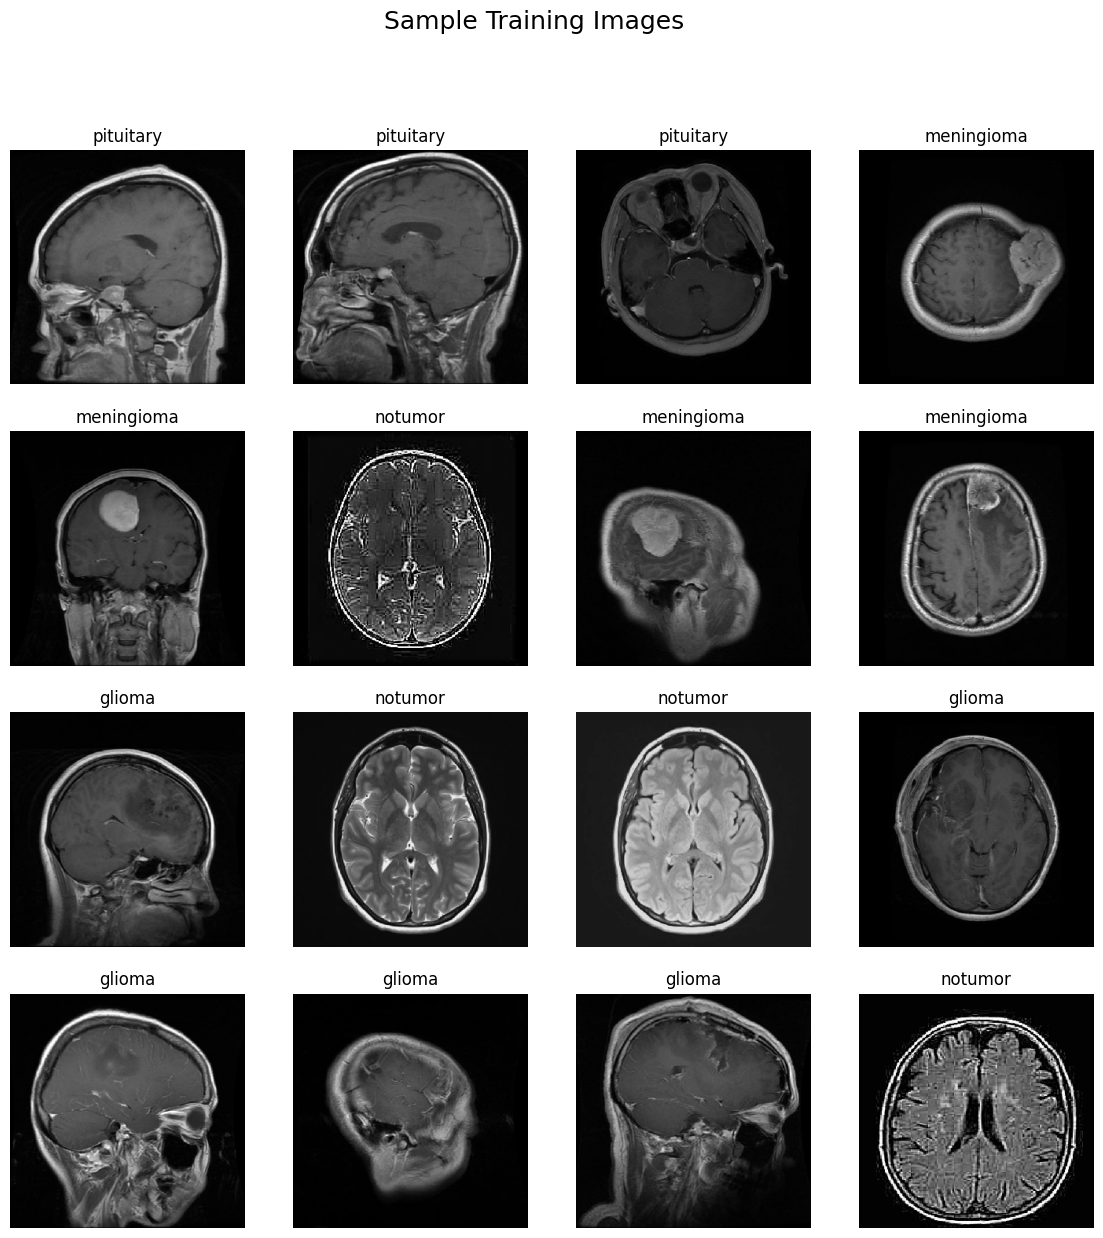

In [8]:
def show_sample_images(generator, n=16):
    images, labels = next(generator)
    class_labels = list(generator.class_indices.keys())
    plt.figure(figsize=(14, 14))
    for i in range(n):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(class_labels[np.argmax(labels[i])])
        plt.axis('off')
    plt.suptitle("Sample Training Images", fontsize=18)
    plt.show()

show_sample_images(train_generator)

# performance (Loss, Accuracy, Precision, Recall)

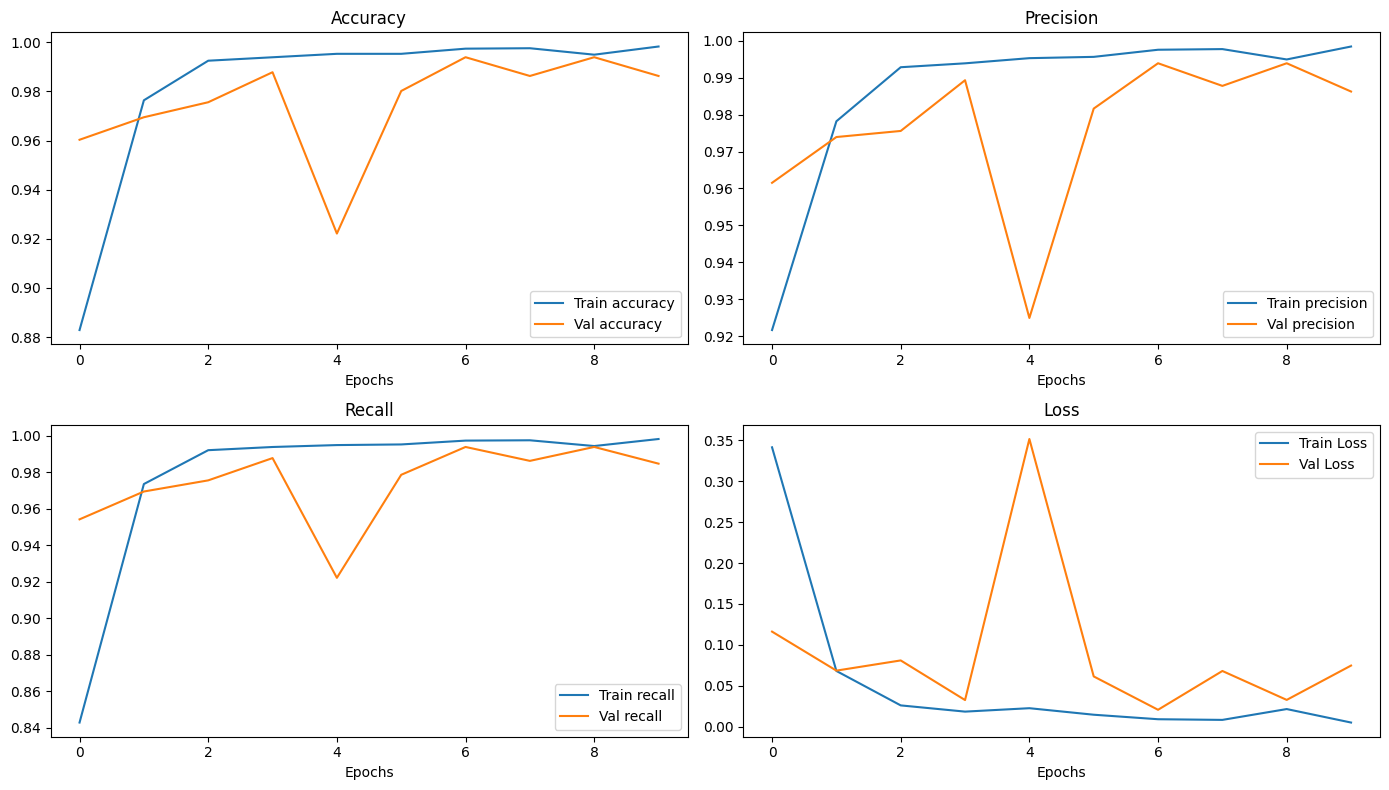

In [9]:
def plot_training_history(history):
    metrics = ['accuracy', 'precision', 'recall']
    plt.figure(figsize=(14, 8))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history['val_' + metric], label=f'Val {metric}')
        plt.title(metric.title())
        plt.xlabel('Epochs')
        plt.legend()
    plt.subplot(2, 2, 4)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# (Confusion Matrix , Classification Report)


21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step


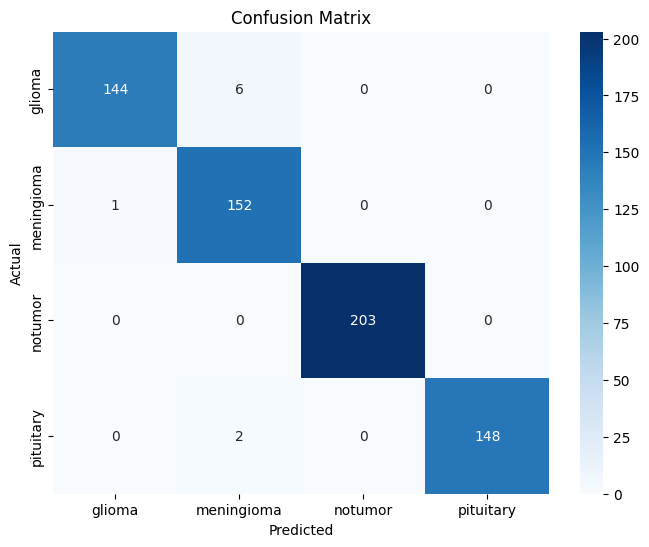


 Classification Report:

              precision    recall  f1-score   support

      glioma       0.99      0.96      0.98       150
  meningioma       0.95      0.99      0.97       153
     notumor       1.00      1.00      1.00       203
   pituitary       1.00      0.99      0.99       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



In [10]:
y_probs = model.predict(test_generator)
y_pred = np.argmax(y_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\n Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Visualization Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


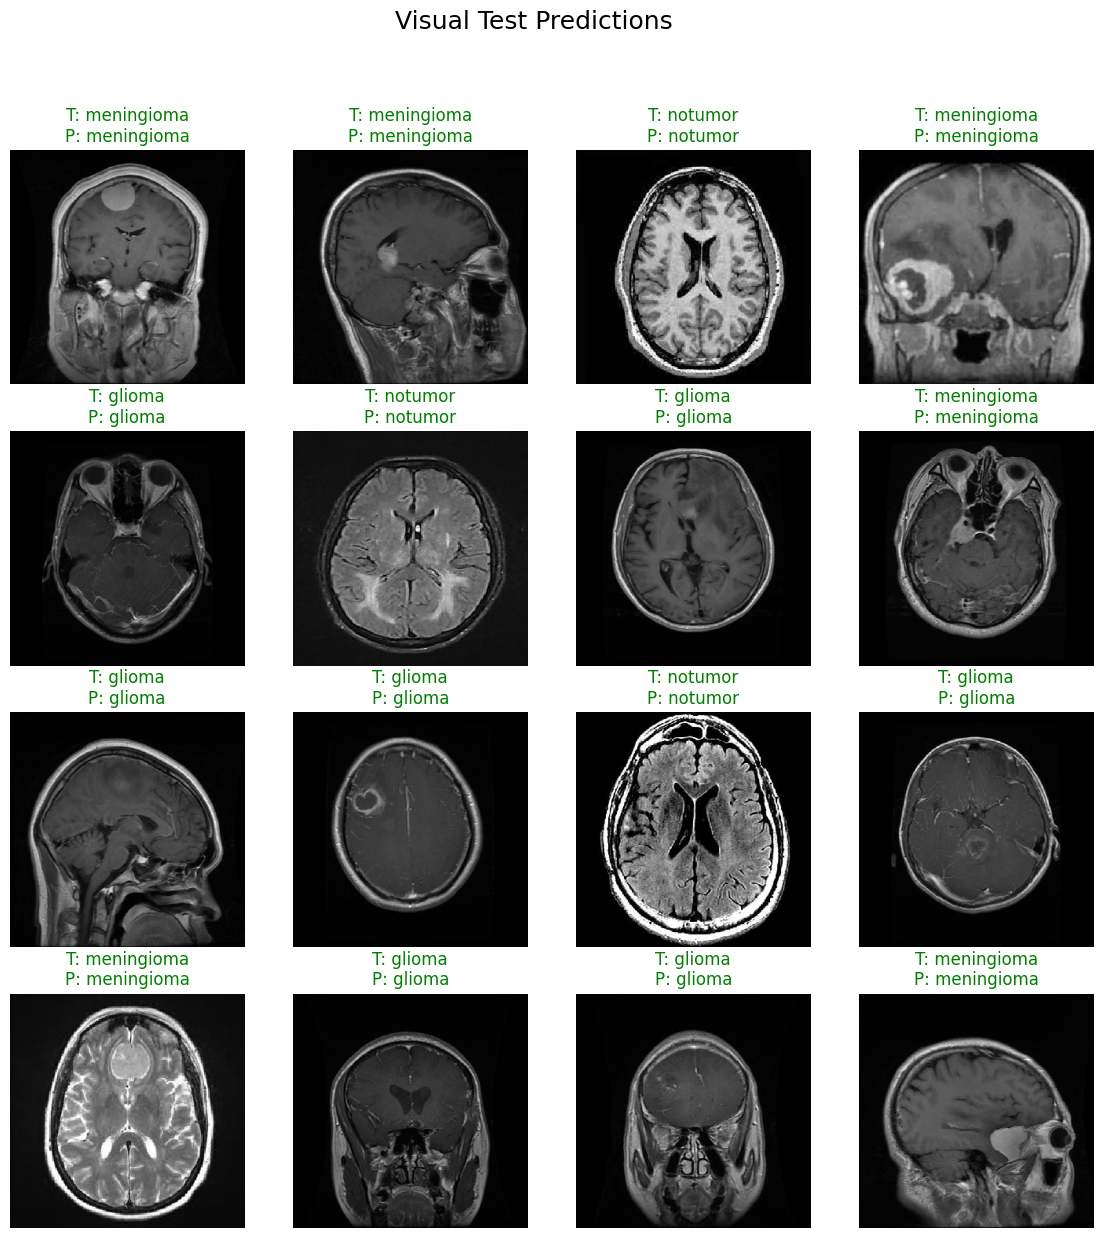

In [11]:
def visualize_test_predictions(generator, model, n=16):
    images, labels = next(generator)
    preds = model.predict(images)
    class_labels = list(generator.class_indices.keys())
    plt.figure(figsize=(14, 14))
    for i in range(n):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        true_label = class_labels[np.argmax(labels[i])]
        pred_label = class_labels[np.argmax(preds[i])]
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"T: {true_label}\nP: {pred_label}", color=color)
        plt.axis('off')
    plt.suptitle("Visual Test Predictions", fontsize=18)
    plt.show()

visualize_test_predictions(test_generator, model)

# model_save

In [12]:
model.save("brain_tumor_model.h5")
print("\n Model saved successfully as 'brain_tumor_model.h5'")



 Model saved successfully as 'brain_tumor_model.h5'


# gradio

In [ ]:
import gradio as gr

def predict_image(img):
    img = img.resize((299, 299))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    preds = model.predict(img_array)
    class_labels = list(test_generator.class_indices.keys())
    return {class_labels[i]: float(preds[0][i]) for i in range(len(class_labels))}

gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=4),
    title=" Brain Tumor Detection",
    description="Upload an MRI image to classify the type of brain tumor."
).launch()